In [61]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

datapath = Path("/home/gercek/scratch/syntax_im/241018")
raw = mne.io.read_raw_fif(datapath / "pilot03.fif", preload=True)
logs2w = pd.read_pickle(datapath / "2024-10-18T16_2word_experiment.pkl")
logs1w = pd.read_pickle(datapath / "2024-10-18T16_1word_experiment.pkl")
statesdf2w: pd.DataFrame = logs2w["states"]
statesdf1w: pd.DataFrame = logs1w["states"]
contdf2w: pd.DataFrame = logs2w["continuous"]
contdf1w: pd.DataFrame = logs1w["continuous"]
f1, f2 = statesdf2w["word1_freq"].unique().dropna()

Opening raw data file /home/gercek/scratch/syntax_im/241018/pilot03.fif...
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 19000 ... 1687999 =     19.000 ...  1687.999 secs
Ready.
Opening raw data file /home/gercek/scratch/

/tmp/ipykernel_757999/1895317152.py:8: RuntimeWarning: This filename (/home/gercek/scratch/syntax_im/241018/pilot03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datapath / "pilot03.fif", preload=True)


In [62]:
triggers = mne.find_events(
    raw, stim_channel="STI102", shortest_event=1, output="offset", consecutive=False
)
endtrig_mask = triggers[:, 2] <= 14
endtrig_t = triggers[endtrig_mask][:, 0]
othertrigs = triggers[~endtrig_mask]

# Get the break times for the 3 subject breaks from the triggers. The final 2 are noise, not breaks.
# Also get the first trigger from the 2-word experiment, which is the end of the first fixation
breaktrigs2w = othertrigs[othertrigs[:, 2] == 15][:3, 0]
firsttrig = endtrig_t[0]
lasttrig2w = triggers[np.searchsorted(triggers[:, 0], breaktrigs2w[-1]) - 1, 0]
# For the 1-word experiment we need to use the first state's start trigger. The log of the initial
# pause state is not saved, as it is overwritten by the first word state.
datastart1w = (raw.annotations.onset[-1] + raw.annotations.duration[-1]) * raw.info["sfreq"]
firstwordtrig1w = othertrigs[np.searchsorted(othertrigs[:, 0], datastart1w), 0]
lasttrig1w = triggers[-1, 0]
aligntrigs = np.hstack([firsttrig, breaktrigs2w[:-1], lasttrig2w, firstwordtrig1w, lasttrig1w])

# Get the corresponding times from the experiment log for those triggers
endfirst2w = statesdf2w.loc[0]["state_end"]
aligntimes2w = statesdf2w.query("state == 'pause'")["state_start"].values
endtime2w = statesdf2w.iloc[-1]["state_end"]
aligntime1w = statesdf1w.loc[1]["state_start"]
endtime1w = statesdf1w.iloc[-1]["state_end"]
aligntimes = np.hstack([endfirst2w, aligntimes2w, endtime2w, aligntime1w, endtime1w])

# Create intervals on which to generate interpolators, and remove the one that links the end of
# the 2-word experiment to the start of the 1-word experiment
trigints = np.lib.stride_tricks.sliding_window_view(aligntrigs, 2)
trigints = np.vstack((trigints[:3], trigints[-1]))  # Pop out the 4th interval
logints = np.lib.stride_tricks.sliding_window_view(aligntimes, 2)
logints = np.vstack((logints[:3], logints[-1]))  # Pop out the 4th interval

interpolators = {
    i: interp1d(x, y, fill_value="extrapolate") for i, (x, y) in enumerate(zip(logints, trigints))
}


def interp_time(t):
    if np.isnan(t) or np.isinf(t):
        return t
    binidx = np.digitize(t, aligntimes[:4], right=True) - 1
    binidx = 0 if binidx < 0 else binidx
    interp = interpolators[binidx]
    return int(interp(t))


# Interpolate the triggers for the 1-word experiment, and create an events array from those
states2wcorr = statesdf2w.copy()
states1wcorr = statesdf1w.copy()
cont2wcorr = contdf2w.copy()
cont1wcorr = contdf1w.copy()
statescols = ["state_start", "state_end", "target_end"]
for col in statescols:
    states2wcorr[col] = states2wcorr[col].map(interp_time)
    states1wcorr[col] = states1wcorr[col].map(interp_time)
cont2wcorr["value"] = cont2wcorr["value"].map(interp_time)
cont1wcorr["value"] = cont1wcorr["value"].map(interp_time)
cont1wcorr.sort_values("value", inplace=True, ignore_index=True)
cont1wcorr.set_index("value", inplace=True)
cont2wcorr.sort_values("value", inplace=True, ignore_index=True)
cont2wcorr.set_index("value", inplace=True)

2590 events found on stim channel STI102


Event IDs: [ 8 10 11 14 15 30 31 32 33 34 35 38 39 40 41 42 43 46 47 56 59 62 63]


In [28]:
freqs = np.hstack([np.arange(1, 10) * 50, np.arange(1, 3) * 240]).T
filtraw = raw.copy().notch_filter(freqs=freqs, picks="MISC010", notch_widths=freqs / 50)

Filtering raw data in 4 contiguous segments
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.019

In [109]:
stim2w = (
    cont2wcorr.set_index(["state_number", "key1"], append=True)
    .groupby(["state_number", "key1"])  # Group by word
    .cumcount()  # Generate a running count of each word's occurrences
    .add(1)  # Start the count from 1
    .unstack(2)  # Pivot the table so that each word is a column
    .ffill()  # Fill the NaNs with the last count at that time sampe
    .fillna(0)  # Fill the NaNs at the beginning of the experiment with 0
    .astype(int)  # Convert the counts to integers
    .map(
        lambda i: np.bool(i % 2)
    )  # Map the counts to a boolean array. Even numbers of flips are True
)
x = stim2w.index.get_level_values("value")
interp2w_w1 = interp1d(x, stim2w["word1"], kind="previous", fill_value=np.bool(False))
interp2w_w2 = interp1d(x, stim2w["word2"], kind="previous", fill_value=np.bool(False))

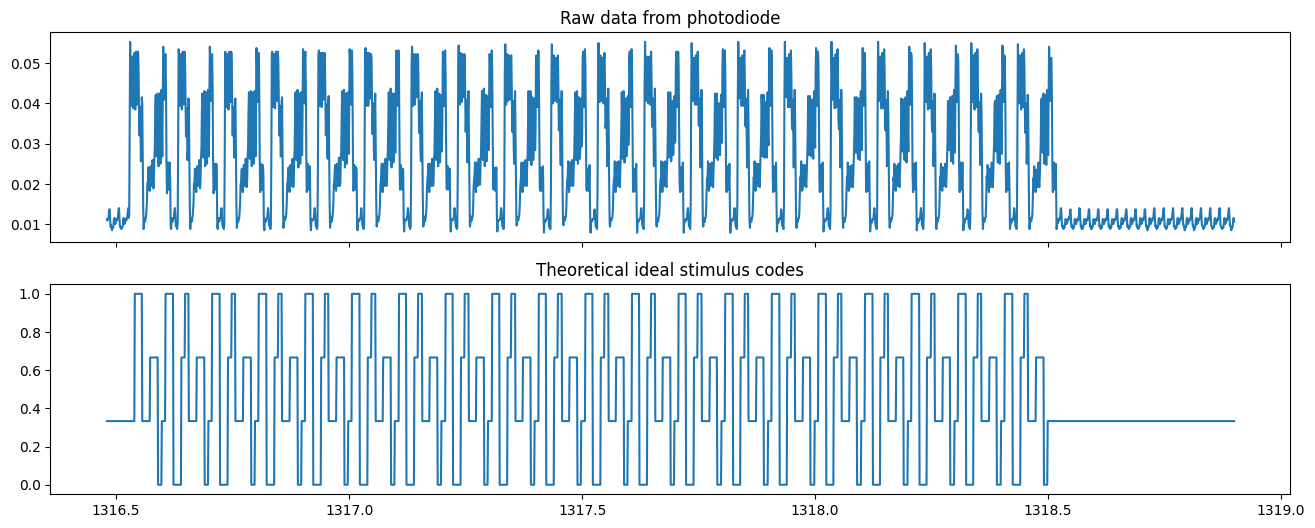

In [134]:
codes = np.array([[-1, -1 / 3], [1 / 3, 1]])
tmin, tmax = 1316.48, 1318.9
smin, smax = raw.time_as_index(tmin)[0], raw.time_as_index(tmax)[0]
samps, t = raw.get_data(picks="MISC010", start=smin, stop=smax, return_times=True)
idxs = np.arange(smin, smax)
samps = samps.squeeze()
state = np.vstack(
    (interp2w_w1(idxs + raw.first_samp + 5), interp2w_w2(idxs + raw.first_samp + 5))
).astype(int)
codemap = codes[state[0], state[1]]
codemap = (codemap + 1) / 2
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 6))
ax[0].plot(t, samps.squeeze())
ax[0].set_title("Raw data from photodiode")
ax[1].plot(t, codemap)
ax[1].set_title("Theoretical ideal stimulus codes")

plt.show()

In [114]:
np.arange(smin, smax).shape

(1200,)

Index([  24475,   24484,   24492,   24509,   24525,   24534,   24542,   24559,
         24575,   24584,
       ...
       2166090, 2166098, 2166115, 2166132, 2166140, 2166148, 2166165, 2166182,
       2166190, 2166198],
      dtype='int64', name='value', length=85789)